In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.io_utils import load_multiple_res
from utils.pd_utils import compute_outlier_scores, transform_dgms, filter_dgms, compute_wide_gap_scores
from utils.fig_utils import full_dist_to_print, dist_to_color, dist_to_print, dataset_to_print, intersect_at_zero
import os
import numpy as np

env: CUDA_VISIBLE_DEVICES=1


In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Fig datasets

In [4]:
datasets = ["toy_circle", "inter_circles", "eyeglasses", "torus", "toy_sphere"]

embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000

# different datas
sigmas_per_dataset = {}
for dataset in datasets:
    if dataset == "eyeglasses":
        sigmas_per_dataset[dataset] = sigmas[:13]
    else:
        sigmas_per_dataset[dataset] = sigmas

## Find best hyperparameters

In [5]:
# The best hyperparameters are hard-coded below and do not have to be reselected, unless the set of methods and possible hyperparameters is changed.

In [6]:
distances = {
    "euclidean": [{}],
    "fermat": [
               {"p": 2},
               {"p": 3},
               {"p": 5},
               {"p": 7}
               ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
            {"k": 4, "p_dtm": np.inf, "p_radius": 1},
            {"k": 15, "p_dtm": 2, "p_radius": 1},
            {"k": 15, "p_dtm": np.inf, "p_radius": 1},
            {"k": 100, "p_dtm": 2, "p_radius": 1},
            {"k": 100, "p_dtm": np.inf, "p_radius": 1},

            {"k": 4, "p_dtm": 2, "p_radius": 2},
            {"k": 4, "p_dtm": np.inf, "p_radius": 2},
            {"k": 15, "p_dtm": 2, "p_radius": 2},
            {"k": 15, "p_dtm": np.inf, "p_radius": 2},
            {"k": 100, "p_dtm": 2, "p_radius": 2},
            {"k": 100, "p_dtm": np.inf, "p_radius": 2},

            {"k": 4, "p_dtm": 2, "p_radius": np.inf},
            {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 15, "p_dtm": 2, "p_radius": np.inf},
            {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 100, "p_dtm": 2, "p_radius": np.inf},
            {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}


In [7]:
#load data
all_res = {}
for dataset in datasets:
    all_res[dataset] = load_multiple_res(datasets=dataset,
                                         distances=distances,
                                         root_path=get_path("data"),
                                         n=n,
                                         seeds=seeds,
                                         sigmas=sigmas_per_dataset[dataset],
                                         embd_dims=embd_dim,
                                         n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_2 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_3 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_5 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_7 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_15_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_15_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_100_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_100_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_2 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_inf_p_radius_2 n_outliers=0, pertur

In [8]:
# compute the detection score
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "inter_circles": 2,
        "eyeglasses": 1,
        "torus": 2,
        "toy_sphere": 0,  # so that the curves are high for AUC
    },
    2: {
        "toy_sphere": 1,
        "torus": 1 
    }
}

# Classification mode

In [9]:
# filtering
dob = 1.25
all_res = filter_dgms(dgms=all_res, dob=dob, dim=1, binary=True)
all_res = filter_dgms(dgms=all_res, dob=dob, dim=2, binary=True)


KeyboardInterrupt



In [112]:
wide_gap_class_scores_1d = {dataset: compute_wide_gap_scores(all_res[dataset], 
                                                     n_features=cycles_per_dataset[1][dataset],
                                                     dim=1,
                                                     n_gap=0,
                                                     mode="classification")
                     for dataset in cycles_per_dataset[1]}

wide_gap_class_scores_2d = {dataset: compute_wide_gap_scores(all_res[dataset],
                                                             n_features=cycles_per_dataset[2][dataset],
                                                             dim=2,
                                                             n_gap=0,
                                                             mode="classification")
                     for dataset in cycles_per_dataset[2]}

wide_gap_class_scores = {
    1: wide_gap_class_scores_1d,
    2: wide_gap_class_scores_2d
}

In [113]:
# compute area under the curves
aucs = {}

for feature_dim in wide_gap_class_scores:
    auc_by_feature_dim = {}
    for dataset in wide_gap_class_scores[feature_dim]:
        auc_by_dataset = {}
        for dist in wide_gap_class_scores[feature_dim][dataset]:
            auc_per_method = {}
            for full_dist in wide_gap_class_scores[feature_dim][dataset][dist]:
                auc_per_method[full_dist] = wide_gap_class_scores[feature_dim][dataset][dist][full_dist].mean(1).sum() / len(sigmas_per_dataset[dataset])
            auc_by_dataset[dist] = auc_per_method
        auc_by_feature_dim[dataset] = auc_by_dataset
    aucs[feature_dim] = auc_by_feature_dim

In [114]:
# Each panel selects the best method individually. This means different feature dimensions for torus and sphere can select different hyperparameters.

best_method_per_dataset = {}
for feature_dim in aucs:
    best_method_per_feature_dim = {}

    for dataset in aucs[feature_dim]:
        best_method_this_dataset = {}
        for dist in aucs[feature_dim][dataset]:
            best_full_dist = None
            best_auc = 0
            for full_dist in aucs[feature_dim][dataset][dist]:
                auc = aucs[feature_dim][dataset][dist][full_dist]
                if auc > best_auc:
                    best_auc = auc
                    best_full_dist = full_dist
            
            # if all settings are equally bad, select the first one
            if best_full_dist is None:
                best_full_dist = list(aucs[feature_dim][dataset][dist].keys())[0]
                
            best_method_this_dataset[dist] = best_full_dist
        best_method_per_feature_dim[dataset] = best_method_this_dataset
    best_method_per_dataset[feature_dim] = best_method_per_feature_dim

In [115]:
# print best hyperparameter settings 
for feature_dim in best_method_per_dataset:
    print("~"*40)
    print(f"Topological dimension: {feature_dim}")
    for dataset in best_method_per_dataset[feature_dim]:
        for dist in best_method_per_dataset[feature_dim][dataset]:
            print(dataset_to_print[dataset], full_dist_to_print[best_method_per_dataset[feature_dim][dataset][dist]].replace("\n", " "))
        print("\n")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Topological dimension: 1
Circle Euclidean
Circle Fermat $p=2$
Circle DTM $k=4, p=2, \xi=1$
Circle Effective resistance $k=100$
Circle Diffusion $k=15, t=8$


Linked circles Euclidean
Linked circles Fermat $p=7$
Linked circles DTM $k=4, p=2, \xi=1$
Linked circles Effective resistance $k=15$
Linked circles Diffusion $k=100, t=8$


Eyeglasses Euclidean
Eyeglasses Fermat $p=5$
Eyeglasses DTM $k=4, p=2, \xi=1$
Eyeglasses Effective resistance $k=15$
Eyeglasses Diffusion $k=15, t=64$


Torus Euclidean
Torus Fermat $p=2$
Torus DTM $k=4, p=2, \xi=1$
Torus Effective resistance $k=15$
Torus Diffusion $k=15, t=8$


Sphere Euclidean
Sphere Fermat $p=2$
Sphere DTM $k=100, p=2, \xi=1$
Sphere Effective resistance $k=15$
Sphere Diffusion $k=100, t=64$


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Topological dimension: 2
Sphere Euclidean
Sphere Fermat $p=7$
Sphere DTM $k=15, p=\infty, \xi=2$
Sphere Effective resistance $k=100$
Sphere Diffusion $k=100, t=8$


Torus 

In [116]:
selected_res = {}
for feature_dim in best_method_per_dataset:
    sel_res_dim = {}
    for dataset in best_method_per_dataset[feature_dim]:
        sel_res_dataset = {}
        for k, v in best_method_per_dataset[feature_dim][dataset].items():
            sel_res_dataset[k] ={k: all_res[dataset][k][v]}
        sel_res_dim[dataset] = sel_res_dataset
    selected_res[feature_dim] = sel_res_dim

In [117]:
# filtering
dob = 1.25
for feature_dim in selected_res:
    selected_res[feature_dim] = filter_dgms(dgms=selected_res[feature_dim], dob=dob, binary=True, dim=feature_dim)

In [118]:
# compute the detection scores for each method
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "eyeglasses": 1,
        "toy_sphere": 0,  # so that the curves are low
        "torus": 2,
        "inter_circles": 2,
        #"toy_blob": 1, # so that the curves are low
    },
    2: {
        "toy_sphere": 1,
        "torus": 1 
    }
}
selected_wide_gap_class_scores_1d = {dataset: compute_wide_gap_scores(selected_res[1][dataset],
                                                              n_features=cycles_per_dataset[1][dataset],
                                                              dim=1,
                                                                      n_gap=0,
                                                                      mode="classification")
                     for dataset in cycles_per_dataset[1]}
selected_wide_gap_class_scores_2d = {dataset: compute_wide_gap_scores(selected_res[2][dataset],
                                                              n_features=cycles_per_dataset[2][dataset],
                                                              dim=2,
                                                                       n_gap=0,
                                                                      mode="classification")
                     for dataset in cycles_per_dataset[2]}

selected_wide_gap_class_scores = {
    1: selected_wide_gap_class_scores_1d,
    2: selected_wide_gap_class_scores_2d,
}


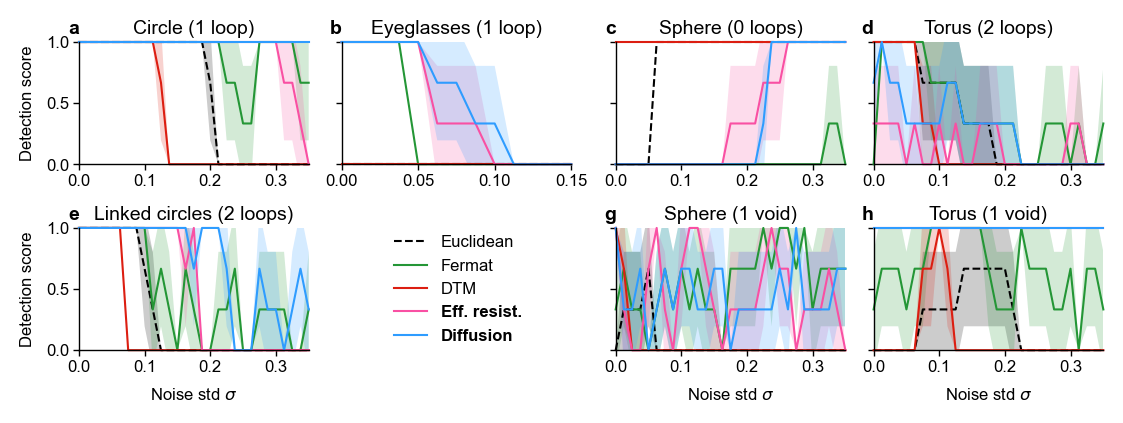

In [121]:
# plot figure
npanels = len(cycles_per_dataset[1]) + len(cycles_per_dataset[2]) +1
nrows = 2
ncols =  int(np.ceil(npanels /2))


fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5.5, 2.))

y_label="Detection score"

letters = "abcdefgh"

shift = 0

for i in range(npanels):
    feature_dim = 1 if i < len(cycles_per_dataset[1]) else 2
    if i == 5: 
        shift = 1
        continue
    j = (i-shift) % len(cycles_per_dataset[1])
    dataset = list(cycles_per_dataset[feature_dim].keys())[j]
    
    r, c  = int(i / ncols), i % ncols
    
    for dist in selected_res[feature_dim][dataset]:
        full_dist = list(selected_res[feature_dim][dataset][dist].keys())[0]
        mean = selected_wide_gap_class_scores[feature_dim][dataset][dist][full_dist].mean(1)
        std = selected_wide_gap_class_scores[feature_dim][dataset][dist][full_dist].std(1)
        
        if dist != "euclidean":
            ax[r, c].plot(sigmas_per_dataset[dataset], 
                       mean,
                       label=dist_to_print[dist],
                       color=dist_to_color[dist],
                       clip_on=False)
            ax[r, c].fill_between(
                sigmas_per_dataset[dataset],
                mean - std,
                mean + std,
                alpha=0.2,
                color=dist_to_color[dist],
                edgecolor=None,
            )
            
        else:
            ax[r, c].plot(sigmas_per_dataset[dataset], 
                          mean,
                          label=dist_to_print[dist],
                          color=dist_to_color[dist],
                          clip_on=False,
                          linestyle="dashed")
            ax[r, c].fill_between(
                sigmas_per_dataset[dataset],
                mean - std,
                mean + std,
                alpha=0.2,
                color=dist_to_color[dist],
                edgecolor=None,
            )       
        
    ax[r, c].set_ylim(0, 1)
    ax[r, c].set_xlim(0, sigmas_per_dataset[dataset].max())
    ax[r, c].set_xlabel("Noise std $\sigma$")
    if c==0:
        ax[r, c].set_ylabel(y_label)
        
    if c > 0:
        ax[r, c].set_yticklabels([])
    if r == 0:
        ax[r, c].set_xlabel("")
        
        
    if i == 0 or i==1:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (1 loop)")
    elif i == 2:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (0 loops)")
    elif i==3 or i==4:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (2 loops)")
    elif i==6 or i==7:
        ax[r, c].set_title(dataset_to_print[dataset] + f" (1 void)")  
    
    
    ax[r, c].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)


handles, labels = ax[1, 2].get_legend_handles_labels()
legend = ax[1, 1].legend(loc=(0.2, 0.0),
                handles=handles,
             frameon=False
      )

leg_labels = legend.get_texts()
leg_labels[-2].set_weight("bold")
leg_labels[-1].set_weight("bold")

ax[1, 1].axis("off")
fig.savefig(os.path.join(fig_path, "fig_datasets_gap_filtered.png"))

In [122]:
best_method_per_dataset[1]["torus"]["eff_res"]

'eff_res_corrected_True_weighted_False_k_15_disconnect_True'

In [ ]:
all_res["torus"]["eff_res"]

# many random seeds on 1D datasets

In [10]:
from utils.fig_utils import plot_dgm_loops
from utils.toydata_utils import get_toy_data
from sklearn.decomposition import PCA

In [11]:
datasets = ["toy_circle", "inter_circles", "eyeglasses"]

embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = np.arange(10, dtype=int)#[0, 1, 2]
n = 1000

# different datas
sigmas_per_dataset = {}
for dataset in datasets:
    if dataset == "eyeglasses":
        sigmas_per_dataset[dataset] = sigmas[:13]
    else:
        sigmas_per_dataset[dataset] = sigmas

## Find best hyperparameters

In [12]:
# The best hyperparameters are hard-coded below and do not have to be reselected, unless the set of methods and possible hyperparameters is changed.

In [13]:
distances = {
    "euclidean": [{}],
    "fermat": [
               {"p": 2},
               {"p": 3},
               {"p": 5},
               {"p": 7}
               ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
            {"k": 4, "p_dtm": np.inf, "p_radius": 1},
            {"k": 15, "p_dtm": 2, "p_radius": 1},
            {"k": 15, "p_dtm": np.inf, "p_radius": 1},
            {"k": 100, "p_dtm": 2, "p_radius": 1},
            {"k": 100, "p_dtm": np.inf, "p_radius": 1},

            {"k": 4, "p_dtm": 2, "p_radius": 2},
            {"k": 4, "p_dtm": np.inf, "p_radius": 2},
            {"k": 15, "p_dtm": 2, "p_radius": 2},
            {"k": 15, "p_dtm": np.inf, "p_radius": 2},
            {"k": 100, "p_dtm": 2, "p_radius": 2},
            {"k": 100, "p_dtm": np.inf, "p_radius": 2},

            {"k": 4, "p_dtm": 2, "p_radius": np.inf},
            {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 15, "p_dtm": 2, "p_radius": np.inf},
            {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 100, "p_dtm": 2, "p_radius": np.inf},
            {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True,}
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
}


In [14]:
#load data
all_res = {}
for dataset in datasets:
    all_res[dataset] = load_multiple_res(datasets=dataset,
                                         distances=distances,
                                         root_path=get_path("data"),
                                         n=n,
                                         seeds=seeds,
                                         sigmas=sigmas_per_dataset[dataset],
                                         embd_dims=embd_dim,
                                         n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_2 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_3 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_5 n_outliers=0, perturbation=None
Done with toy_circle 50 fermat_p_7 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_15_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_15_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_100_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_100_p_dtm_inf_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_2 n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_inf_p_radius_2 n_outliers=0, pertur

In [15]:
# compute the detection score
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "inter_circles": 2,
        "eyeglasses": 1,
        #"torus": 2,
        #"toy_sphere": 0,  # so that the curves are high for AUC
    },
    #2: {
    #    "toy_sphere": 1,
    #    "torus": 1 
    #}
}

# Classification mode

In [16]:
# filtering
dob = 1.25
all_res = filter_dgms(dgms=all_res, dob=dob, dim=1, binary=True)
#all_res = filter_dgms(dgms=all_res, dob=dob, dim=2, binary=True)

In [17]:
wide_gap_class_scores_1d = {dataset: compute_wide_gap_scores(all_res[dataset], 
                                                     n_features=cycles_per_dataset[1][dataset],
                                                     dim=1,
                                                     n_gap=0,
                                                     mode="classification")
                     for dataset in cycles_per_dataset[1]}

#wide_gap_class_scores_2d = {dataset: compute_wide_gap_scores(all_res[dataset],
#                                                             n_features=cycles_per_dataset[2][dataset],
#                                                             dim=2,
#                                                             n_gap=0,
#                                                             mode="classification")
#                     for dataset in cycles_per_dataset[2]}

wide_gap_class_scores = {
    1: wide_gap_class_scores_1d,
    #2: wide_gap_class_scores_2d
}

In [18]:
# compute area under the curves
aucs = {}

for feature_dim in wide_gap_class_scores:
    auc_by_feature_dim = {}
    for dataset in wide_gap_class_scores[feature_dim]:
        auc_by_dataset = {}
        for dist in wide_gap_class_scores[feature_dim][dataset]:
            auc_per_method = {}
            for full_dist in wide_gap_class_scores[feature_dim][dataset][dist]:
                auc_per_method[full_dist] = wide_gap_class_scores[feature_dim][dataset][dist][full_dist].mean(1).sum() / len(sigmas_per_dataset[dataset])
            auc_by_dataset[dist] = auc_per_method
        auc_by_feature_dim[dataset] = auc_by_dataset
    aucs[feature_dim] = auc_by_feature_dim

In [19]:
# Each panel selects the best method individually. This means different feature dimensions for torus and sphere can select different hyperparameters.

best_method_per_dataset = {}
for feature_dim in aucs:
    best_method_per_feature_dim = {}

    for dataset in aucs[feature_dim]:
        best_method_this_dataset = {}
        for dist in aucs[feature_dim][dataset]:
            best_full_dist = None
            best_auc = 0
            for full_dist in aucs[feature_dim][dataset][dist]:
                auc = aucs[feature_dim][dataset][dist][full_dist]
                if auc > best_auc:
                    best_auc = auc
                    best_full_dist = full_dist
            
            # if all settings are equally bad, select the first one
            if best_full_dist is None:
                best_full_dist = list(aucs[feature_dim][dataset][dist].keys())[0]
                
            best_method_this_dataset[dist] = best_full_dist
        best_method_per_feature_dim[dataset] = best_method_this_dataset
    best_method_per_dataset[feature_dim] = best_method_per_feature_dim

In [20]:
# print best hyperparameter settings 
for feature_dim in best_method_per_dataset:
    print("~"*40)
    print(f"Topological dimension: {feature_dim}")
    for dataset in best_method_per_dataset[feature_dim]:
        for dist in best_method_per_dataset[feature_dim][dataset]:
            print(dataset_to_print[dataset], full_dist_to_print[best_method_per_dataset[feature_dim][dataset][dist]].replace("\n", " "))
        print("\n")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Topological dimension: 1
Circle Euclidean
Circle Fermat $p=2$
Circle DTM $k=4, p=2, \xi=1$
Circle Effective resistance $k=100$
Circle Diffusion $k=15, t=8$


Linked circles Euclidean
Linked circles Fermat $p=5$
Linked circles DTM $k=4, p=2, \xi=1$
Linked circles Effective resistance $k=100$
Linked circles Diffusion $k=15, t=8$


Eyeglasses Euclidean
Eyeglasses Fermat $p=7$
Eyeglasses DTM $k=4, p=2, \xi=1$
Eyeglasses Effective resistance $k=15$
Eyeglasses Diffusion $k=15, t=8$




In [21]:
selected_res = {}
for feature_dim in best_method_per_dataset:
    sel_res_dim = {}
    for dataset in best_method_per_dataset[feature_dim]:
        sel_res_dataset = {}
        for k, v in best_method_per_dataset[feature_dim][dataset].items():
            sel_res_dataset[k] ={k: all_res[dataset][k][v]}
        sel_res_dim[dataset] = sel_res_dataset
    selected_res[feature_dim] = sel_res_dim

In [22]:
# filtering
dob = 1.25
for feature_dim in selected_res:
    selected_res[feature_dim] = filter_dgms(dgms=selected_res[feature_dim], dob=dob, binary=True, dim=feature_dim)

In [23]:
# compute the detection scores for each method
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "eyeglasses": 1,
        #"toy_sphere": 0,  # so that the curves are high
        #"torus": 2,
        "inter_circles": 2,
        #"toy_blob": 1, # so that the curves are low
    },
    #2: {
    #    "toy_sphere": 1,
    #    "torus": 1 
    #}
}
selected_wide_gap_class_scores_1d = {dataset: compute_wide_gap_scores(selected_res[1][dataset],
                                                              n_features=cycles_per_dataset[1][dataset],
                                                              dim=1,
                                                                      n_gap=0,
                                                                      mode="classification")
                     for dataset in cycles_per_dataset[1]}
#selected_wide_gap_class_scores_2d = {dataset: compute_wide_gap_scores(selected_res[2][dataset],
#                                                              n_features=cycles_per_dataset[2][dataset],
#                                                              dim=2,
#                                                                       n_gap=0,
#                                                                      mode="classification")
#                     for dataset in cycles_per_dataset[2]}

selected_wide_gap_class_scores = {
    1: selected_wide_gap_class_scores_1d,
    #2: selected_wide_gap_class_scores_2d,
}


In [24]:
from utils.pd_utils import get_persistent_feature_id

{1: {'toy_circle': 1, 'eyeglasses': 1, 'inter_circles': 2}}


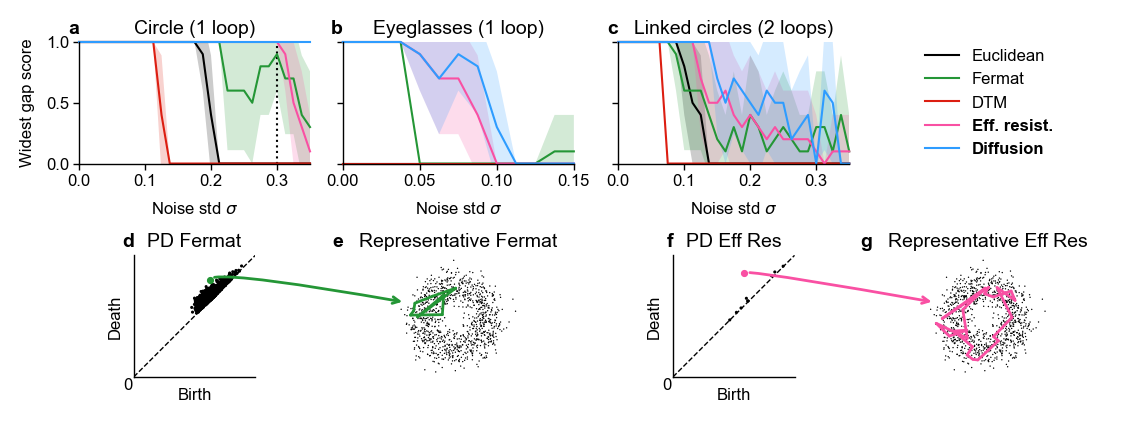

In [27]:
# plot figure

print(cycles_per_dataset)
npanels = len(cycles_per_dataset[1])  +1
nrows = 2
ncols =  4


fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5.5, 2))

y_label="Widest gap score"

letters = "abcdefgh"

shift = 0

for i in range(npanels-1):
    feature_dim = 1 if i < len(cycles_per_dataset[1]) else 2
    if i == 5: 
        shift = 1
        continue
    j = (i-shift) % len(cycles_per_dataset[1])
    dataset = list(cycles_per_dataset[feature_dim].keys())[j]
    
    cax = ax[0, i]
    
    if i ==0:
        cax.axvline(0.3, color="k", linestyle="dotted")
    
    for dist in selected_res[feature_dim][dataset]:
        full_dist = list(selected_res[feature_dim][dataset][dist].keys())[0]
        mean = selected_wide_gap_class_scores[feature_dim][dataset][dist][full_dist].mean(1)
        std = selected_wide_gap_class_scores[feature_dim][dataset][dist][full_dist].std(1)
        
        #if dist != "euclidean":
        cax.plot(sigmas_per_dataset[dataset], 
                   mean,
                   label=dist_to_print[dist],
                   color=dist_to_color[dist],
                   clip_on=False)
        cax.fill_between(
            sigmas_per_dataset[dataset],
            mean - std,
            mean + std,
            alpha=0.2,
            color=dist_to_color[dist],
            edgecolor=None,
        )
            
        #else:
        #    cax.plot(sigmas_per_dataset[dataset], 
        #                  mean,
        #                  label=dist_to_print[dist],
        #                  color=dist_to_color[dist],
        #                  clip_on=False,
        #                  linestyle="dashed")
        #    cax.fill_between(
        #        sigmas_per_dataset[dataset],
        #        mean - std,
        #        mean + std,
        #        alpha=0.2,
        #        color=dist_to_color[dist],
        #        edgecolor=None,
        #    )       
        
    cax.set_ylim(0, 1)
    cax.set_xlim(0, sigmas_per_dataset[dataset].max())
    cax.set_xlabel("Noise std $\sigma$")
    if i==0:
        cax.set_ylabel(y_label)
        
    if i > 0:
        cax.set_yticklabels([])

        
        
    if i == 0 or i==1:
        cax.set_title(dataset_to_print[dataset] + f" (1 loop)")
    elif i == 2:
        cax.set_title(dataset_to_print[dataset] + f" (2 loops)")
    
    
    cax.set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)


handles, labels = ax[0,0].get_legend_handles_labels()
legend = ax[0, -1].legend(loc=(0.2, 0.0),
                handles=handles,
             frameon=False
      )

leg_labels = legend.get_texts()
leg_labels[-2].set_weight("bold")
leg_labels[-1].set_weight("bold")

ax[0, -1].axis("off")


# example pers diags and representatives
seed = 1
sigma = 0.3
res_fermat = selected_res[1]["toy_circle"]["fermat"]["fermat"][sigma][seed]

loop_id_fermat = get_persistent_feature_id(res_fermat, m=1, dim=1)

pca = PCA(n_components=2).fit_transform(get_toy_data(n=n, dataset="toy_circle", d=50, seed=seed, **{"gaussian": {"sigma": sigma}}))

# omit max norm point
norms = np.linalg.norm(pca, axis=1)
pca = pca[norms < norms.max()]

plot_dgm_loops(res=res_fermat,
               embd=pca,
                   y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=1,
                   colors=["k", dist_to_color["fermat"]], 
                   confidence=None,
                   ax=ax[1, :2],
                   linewidth=1,
                   style=style_file,
                   plot_loops=True,
               zero_intersection=True,
                   )

res_eff_res = selected_res[1]["toy_circle"]["eff_res"]["eff_res"][sigma][seed]
loop_id_eff_res = get_persistent_feature_id(res_eff_res, m=1, dim=1)

plot_dgm_loops(res=res_eff_res,
               embd=pca,
                   y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=1,
                   colors=["k", dist_to_color["eff_res"]], 
                   confidence=None,
                   ax=ax[1, 2:],
                   linewidth=1,
                   style=style_file,
                   plot_loops=True,
               zero_intersection=True
                   )

methods = ["Fermat", "Eff Res"]

for i in range(2):
    cax = ax[1, i*2]
    cax.legend().set_visible(False)
    cax.set_xticks([])
    cax.set_yticks([])
    
    cax.set_title(f"PD {methods[i]}")
    cax.set_title(
        letters[2*i+3],
        loc="left",
        ha="right",
        fontweight="bold",)
    
    cax = ax[1, i*2+1]
    cax.set_title(f"Representative {methods[i]}")
    cax.set_title(
        letters[2*i+1+3],
        loc="left",
        ha="right",
        fontweight="bold",)
    
    
# add arrows

annot = plt.Annotation(
    "",
    xy=(-1.5,0.5), 
    textcoords=ax[1,0].transData,
    xytext=(res_fermat["dgms"][1][loop_id_fermat]), 
    xycoords=ax[1,1].transData,
    arrowprops=dict(arrowstyle="->", 
                    linewidth=1,
                    connectionstyle="angle3,angleA=90,angleB=-10", 
                    color=dist_to_color["fermat"]),
)
ax[1,1].add_artist(annot)


annot2 = plt.Annotation(
    "",
    xy=(-1.5,0.5), 
    textcoords=ax[1,2].transData,
    xytext=(res_eff_res["dgms"][1][loop_id_eff_res]), 
    xycoords=ax[1,3].transData,
    arrowprops=dict(arrowstyle="->", 
                    linewidth=1,
                    connectionstyle="angle3,angleA=90,angleB=-10", 
                    color=dist_to_color["eff_res"]),
)
ax[1,3].add_artist(annot2)
  

fig.savefig(os.path.join(fig_path, "fig_widest_gap.png"))
fig.savefig(os.path.join(fig_path, "fig_widest_gap.pdf"))

In [111]:
selected_res[1]["toy_circle"]["fermat"]["fermat"].keys()

dict_keys([0.0, 0.0125, 0.025, 0.0375, 0.05, 0.0625, 0.075, 0.0875, 0.1, 0.1125, 0.125, 0.1375, 0.15, 0.1625, 0.175, 0.1875, 0.2, 0.2125, 0.225, 0.2375, 0.25, 0.2625, 0.275, 0.2875, 0.3, 0.3125, 0.325, 0.3375, 0.35])

[0 1 2 4 5 6 7 8 9]


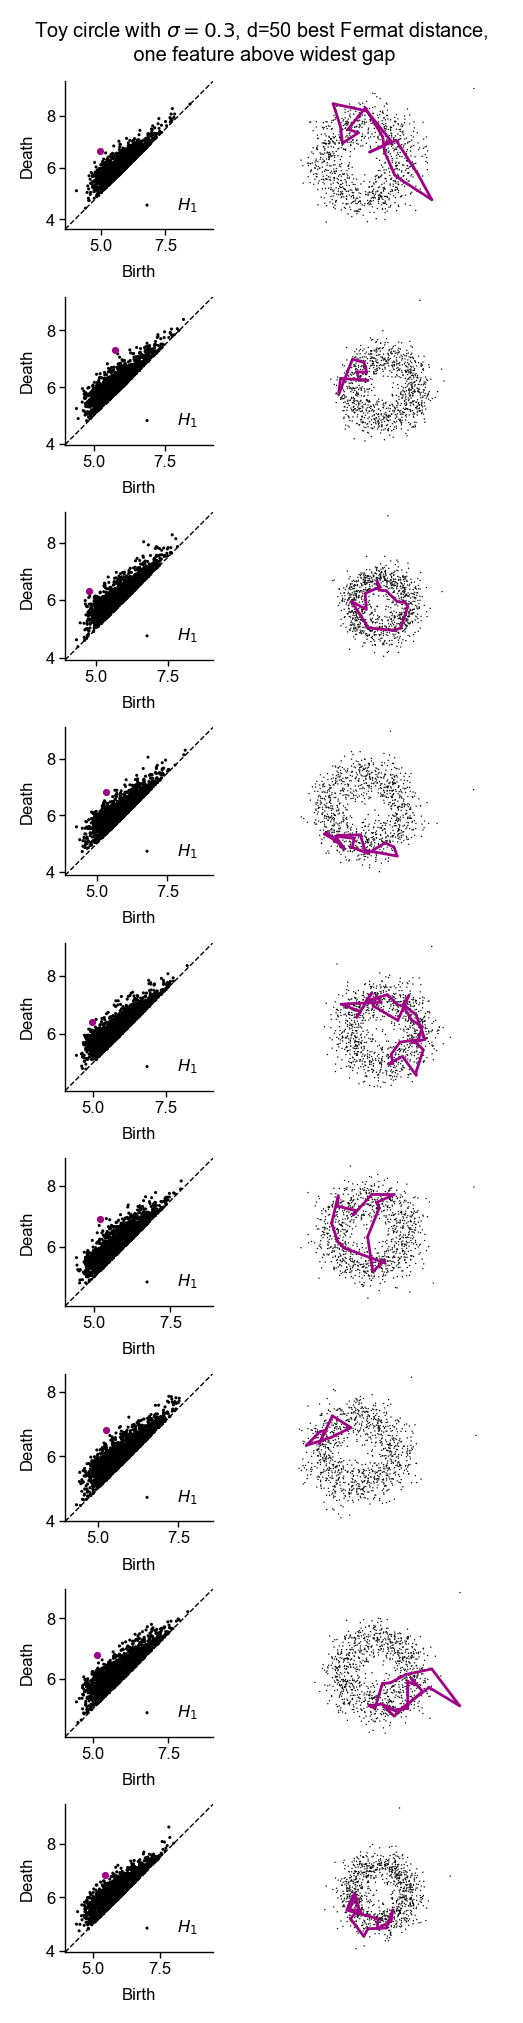

In [106]:
# fermat
distance = "fermat"
full_dist = best_method_per_dataset[1]["toy_circle"][distance]

sigma = 0.3

sigma_id = 24
sel_seeds = np.where(selected_wide_gap_class_scores_1d["toy_circle"][distance][distance][sigma_id])[0]
print(sel_seeds)
data = np.array([get_toy_data(n=n, dataset="toy_circle", d=50, seed=seed, **{"gaussian": {"sigma": sigma}}) for seed in sel_seeds])
ncols = 2
nrows = len(sel_seeds)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2.5, 10))

for r, seed in enumerate(sel_seeds):
    pca = PCA(n_components=2).fit_transform(data[r])
    
    plot_dgm_loops(res=all_res["toy_circle"][distance][full_dist][sigma][seed],
                   embd=pca,
                   y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=1,
                   existing_colors=["k"],
                   confidence=None,
                   ax=ax[r, :],
                   linewidth=1,
                   style=style_file,
                   plot_loops=True,
                   )

fig.suptitle("Toy circle with $\sigma=0.3$, d=50 best Fermat distance,\n one feature above widest gap")
fig.savefig(os.path.join(fig_path, "fig_toy_circle_fermat.png"))

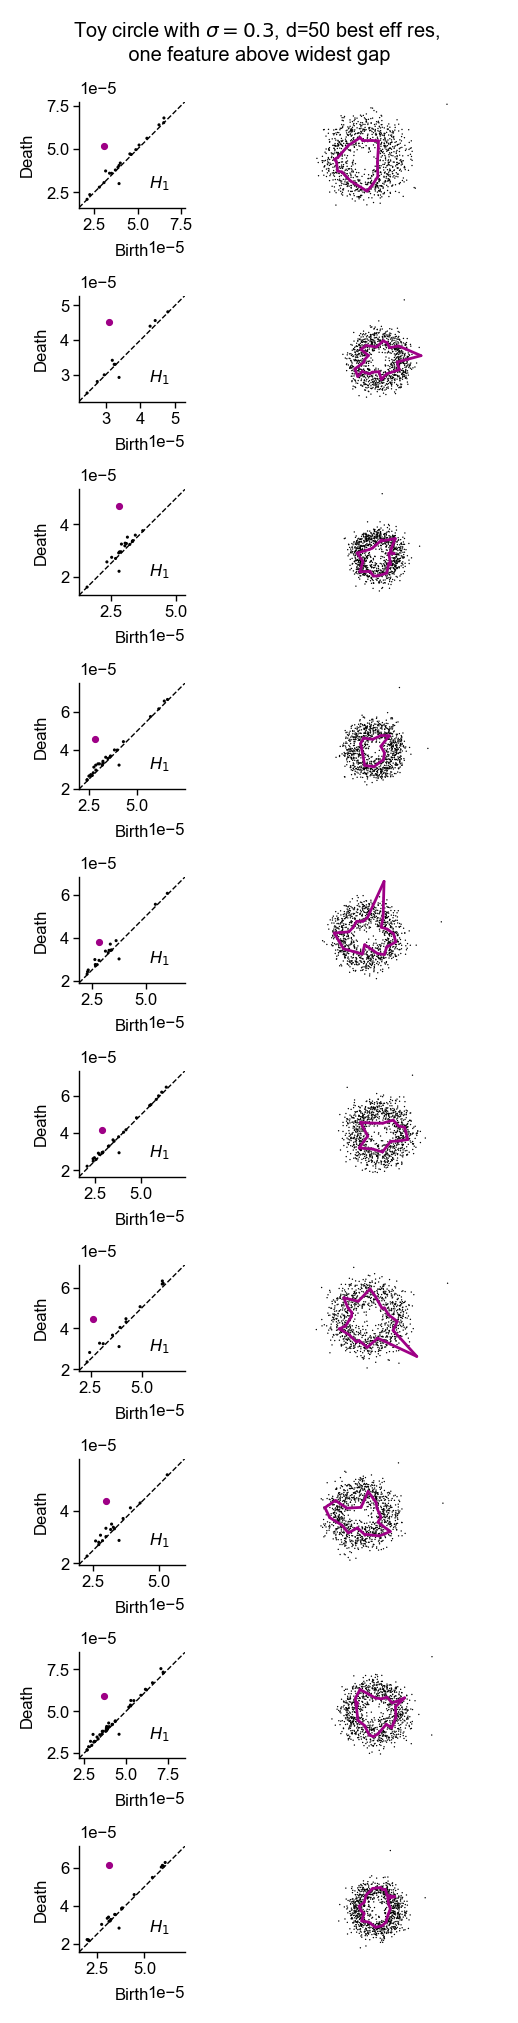

In [79]:
distance = "eff_res"
full_dist = best_method_per_dataset[1]["toy_circle"][distance]

sigma = 0.3

sigma_id = 24
sel_seeds = np.where(selected_wide_gap_class_scores_1d["toy_circle"][distance][distance][sigma_id])[0]

data = np.array([get_toy_data(n=n, dataset="toy_circle", d=50, seed=seed, **{"gaussian": {"sigma": sigma}}) for seed in sel_seeds])
ncols = 2
nrows = len(sel_seeds)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2.5, 10))

for r, seed in enumerate(sel_seeds):
    pca = PCA(n_components=2).fit_transform(data[r])
    
    plot_dgm_loops(res=all_res["toy_circle"][distance][full_dist][sigma][seed],
                   embd=pca,
                   y="k",
                   n_loops=4,
                   n_cols=5,
                   cmap="tab20",
                   plot_only=[1],
                   s=1,
                   existing_colors=["k"],
                   confidence=None,
                   ax=ax[r, :],
                   linewidth=1,
                   style=style_file,
                   plot_loops=True,
                   )
    #plot_diagrams(all_res["toy_circle"]["fermat"][full_dist][sigma][seed]["dgms"], 
    #              ax=ax[r, c], plot_only=[1], size=4, color=dist_to_color["euclidean"], colormap=style_file)

fig.suptitle("Toy circle with $\sigma=0.3$, d=50 best eff res,\n one feature above widest gap")
fig.savefig(os.path.join(fig_path, "fig_toy_circle_eff_res.png"))

# test negative result

In [84]:
repeats = 100 #10
seeds = np.arange(repeats)
n = 1000

embd_dims = [50] #[2, 10, 20, 30, 40, 50]
d = 50
sigma = 0.1
max_dim = 1

distance = "euclidean"

dist_kwargs = {}

dataset = "toy_blob"

In [85]:
from utils.toydata_utils import get_toy_data
from utils.utils import dist_kwargs_to_str, compute_ph
from utils.io_utils import read_ripser_result
from utils.dist_utils import get_dist


In [125]:
for seed in seeds:
    for d in embd_dims:
        # get data
        x = get_toy_data(n=n, dataset=dataset, d=d, seed=seed, **{"gaussian": {"sigma": sigma}})
        # compute PH
       
        file_name = f"{dataset}_{n}_d_{d}_ortho_gauss_sigma_{sigma}_seed_{seed}_{distance}" \
                    + dist_kwargs_to_str(dist_kwargs)
        print(f"Starting with {file_name}")
        # try to load precomputed result
        try:
            res = read_ripser_result(os.path.join(root_path, dataset, file_name+"_rep"))
        # if non-existent compute PH
        except FileNotFoundError:
            print(f"Computing PH for {dataset} with sigma {sigma} and distance {distance} with {dist_kwargs}")
    
            # copy the dict bc we will change it for the embedding based approaches, so that we can nicely save
            # the embedding as well
            dist_kwargs = dist_kwargs.copy()
    
            # update the distance with embedding parameters, needed for saving the embedding itself
            if distance.endswith("embd"):
                dist_kwargs.update({"root_path": os.path.join(root_path, dataset),
                                    "dataset": f"n_{n}_d_{d}_ortho_gauss_sigma_{sigma}",
                                    "seed": seed})
            # compute the distance
            dists = get_dist(x=x, distance=distance, **dist_kwargs)
            # compute peristent homology
            res = compute_ph(dists, file_name, root_path, dataset, dim=max_dim, delete_dists=True)


Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_0_euclidean
Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_0_euclidean
Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_0_euclidean
Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_0_euclidean
Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_0_euclidean
Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_0_euclidean
Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_1_euclidean
Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_1_euclidean
Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_1_euclidean
Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_1_euclidean
Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_1_euclidean
Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_1_euclidean
Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_2_euclidean
Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_2_eucli

reducing column 372097/475732 (diameter 0.237269))

Deleting dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_3_euclidean


Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_3_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_3_euclidean
Running Ripser for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_3_euclidean


reducing column 382620/457986 (diameter 0.504263)

Deleting dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_3_euclidean


Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_3_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_3_euclidean
Running Ripser for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_3_euclidean


reducing column 434907/442519 (diameter 0.734948)

Deleting dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_3_euclidean


Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_3_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_3_euclidean
Running Ripser for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_3_euclidean


reducing column 405233/434361 (diameter 0.85318))

Deleting dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_3_euclidean


Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_3_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_3_euclidean
Running Ripser for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_3_euclidean


reducing column 425208/429529 (diameter 0.992706)

Deleting dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_3_euclidean


Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_3_euclidean
Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_4_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_4_euclidean
Running Ripser for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_4_euclidean


reducing column 359687/486772 (diameter 0.219733))

Deleting dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_4_euclidean


Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_4_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_4_euclidean
Running Ripser for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_4_euclidean


reducing column 367751/456097 (diameter 0.494675)

Deleting dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_4_euclidean


Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_4_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_4_euclidean
Running Ripser for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_4_euclidean


reducing column 314293/439159 (diameter 0.651891)

Deleting dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_4_euclidean


Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_4_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_4_euclidean
Running Ripser for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_4_euclidean


reducing column 334413/449072 (diameter 0.805832)

Deleting dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_4_euclidean


Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_4_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_4_euclidean
Running Ripser for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_4_euclidean


reducing column 393569/432815 (diameter 0.965725)

Deleting dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_4_euclidean


Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_4_euclidean
Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_5_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_5_euclidean
Running Ripser for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_5_euclidean


reducing column 481945/482997 (diameter 0.36707)))

Deleting dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_5_euclidean


Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_5_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_5_euclidean
Running Ripser for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_5_euclidean


reducing column 434065/446938 (diameter 0.550247)

Deleting dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_5_euclidean


Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_5_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_5_euclidean
Running Ripser for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_5_euclidean


reducing column 323957/442945 (diameter 0.662468)

Deleting dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_5_euclidean


Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_5_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_5_euclidean
Running Ripser for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_5_euclidean


reducing column 336874/416455 (diameter 0.81412))

Deleting dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_5_euclidean


Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_5_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_5_euclidean
Running Ripser for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_5_euclidean


reducing column 327641/408213 (diameter 0.929556)

Deleting dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_5_euclidean


Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_5_euclidean
Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_6_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_6_euclidean
Running Ripser for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_6_euclidean


reducing column 461137/485019 (diameter 0.308758))

Deleting dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_6_euclidean


Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_6_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_6_euclidean
Running Ripser for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_6_euclidean


reducing column 430322/461098 (diameter 0.540004)

Deleting dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_6_euclidean


Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_6_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_6_euclidean
Running Ripser for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_6_euclidean


reducing column 319067/433188 (diameter 0.653893)

Deleting dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_6_euclidean


Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_6_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_6_euclidean
Running Ripser for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_6_euclidean


reducing column 427338/456010 (diameter 0.871574)

Deleting dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_6_euclidean


Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_6_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_6_euclidean
Running Ripser for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_6_euclidean


reducing column 393052/425759 (diameter 0.966671)

Deleting dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_6_euclidean


Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_6_euclidean
Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_7_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_7_euclidean
Running Ripser for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_7_euclidean


reducing column 384244/483186 (diameter 0.239362))

Deleting dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_7_euclidean


Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_7_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_7_euclidean
Running Ripser for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_7_euclidean


reducing column 312721/433186 (diameter 0.462153)

Deleting dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_7_euclidean


Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_7_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_7_euclidean
Running Ripser for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_7_euclidean


reducing column 352959/404175 (diameter 0.670226)

Deleting dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_7_euclidean


Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_7_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_7_euclidean
Running Ripser for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_7_euclidean


reducing column 353466/402703 (diameter 0.815132)

Deleting dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_7_euclidean


Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_7_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_7_euclidean
Running Ripser for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_7_euclidean


reducing column 400634/432670 (diameter 0.966693)

Deleting dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_7_euclidean


Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_7_euclidean
Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_8_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_8_euclidean
Running Ripser for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_8_euclidean


reducing column 376095/476563 (diameter 0.238785))

Deleting dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_8_euclidean


Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_8_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_8_euclidean
Running Ripser for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_8_euclidean


reducing column 306494/441481 (diameter 0.463897)

Deleting dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_8_euclidean


Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_8_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_8_euclidean
Running Ripser for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_8_euclidean


reducing column 411890/449560 (diameter 0.72141))

Deleting dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_8_euclidean


Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_8_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_8_euclidean
Running Ripser for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_8_euclidean


reducing column 363512/421135 (diameter 0.831604)

Deleting dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_8_euclidean


Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_8_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_8_euclidean
Running Ripser for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_8_euclidean


reducing column 421570/427086 (diameter 0.994079)

Deleting dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_8_euclidean


Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_8_euclidean
Starting with toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_9_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_9_euclidean
Running Ripser for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_9_euclidean


reducing column 337772/471503 (diameter 0.218049))

Deleting dists for toy_blob_1000_d_2_ortho_gauss_sigma_0.1_seed_9_euclidean


Starting with toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_9_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_9_euclidean
Running Ripser for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_9_euclidean


reducing column 380339/408677 (diameter 0.504764)

Deleting dists for toy_blob_1000_d_10_ortho_gauss_sigma_0.1_seed_9_euclidean


Starting with toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_9_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_9_euclidean
Running Ripser for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_9_euclidean


reducing column 425324/441435 (diameter 0.730131)

Deleting dists for toy_blob_1000_d_20_ortho_gauss_sigma_0.1_seed_9_euclidean


Starting with toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_9_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_9_euclidean
Running Ripser for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_9_euclidean


reducing column 354623/413505 (diameter 0.821651)

Deleting dists for toy_blob_1000_d_30_ortho_gauss_sigma_0.1_seed_9_euclidean


Starting with toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_9_euclidean
Computing PH for toy_blob with sigma 0.1 and distance euclidean with {}
Writing dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_9_euclidean
Running Ripser for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_9_euclidean


reducing column 311395/439196 (diameter 0.917384)

Deleting dists for toy_blob_1000_d_40_ortho_gauss_sigma_0.1_seed_9_euclidean


Starting with toy_blob_1000_d_50_ortho_gauss_sigma_0.1_seed_9_euclidean


In [86]:
all_res = load_multiple_res(datasets=dataset,
                           distances={"euclidean": [{}]},
                           root_path=get_path("data"),
                           n=n,
                           seeds=seeds,
                           sigmas=[sigma],
                           embd_dims=embd_dims,
                           n_threads=10)

Done with toy_blob 50 euclidean n_outliers=0, perturbation=None


In [128]:
# only one embd dimension

In [95]:
all_res["euclidean"]["euclidean"][0].keys()

dict_keys(['dgms', 'cycles'])

In [87]:
from utils.pd_utils import get_features_above_gap

In [88]:
n_features_above_widest_gap = np.array([len(get_features_above_gap(all_res["euclidean"]["euclidean"][seed]["dgms"][1], n_gap=0)) for seed in seeds ])

In [90]:
np.unique(n_features_above_widest_gap, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8, 14, 15]),
 array([47, 26, 12,  4,  3,  1,  4,  1,  1,  1]))

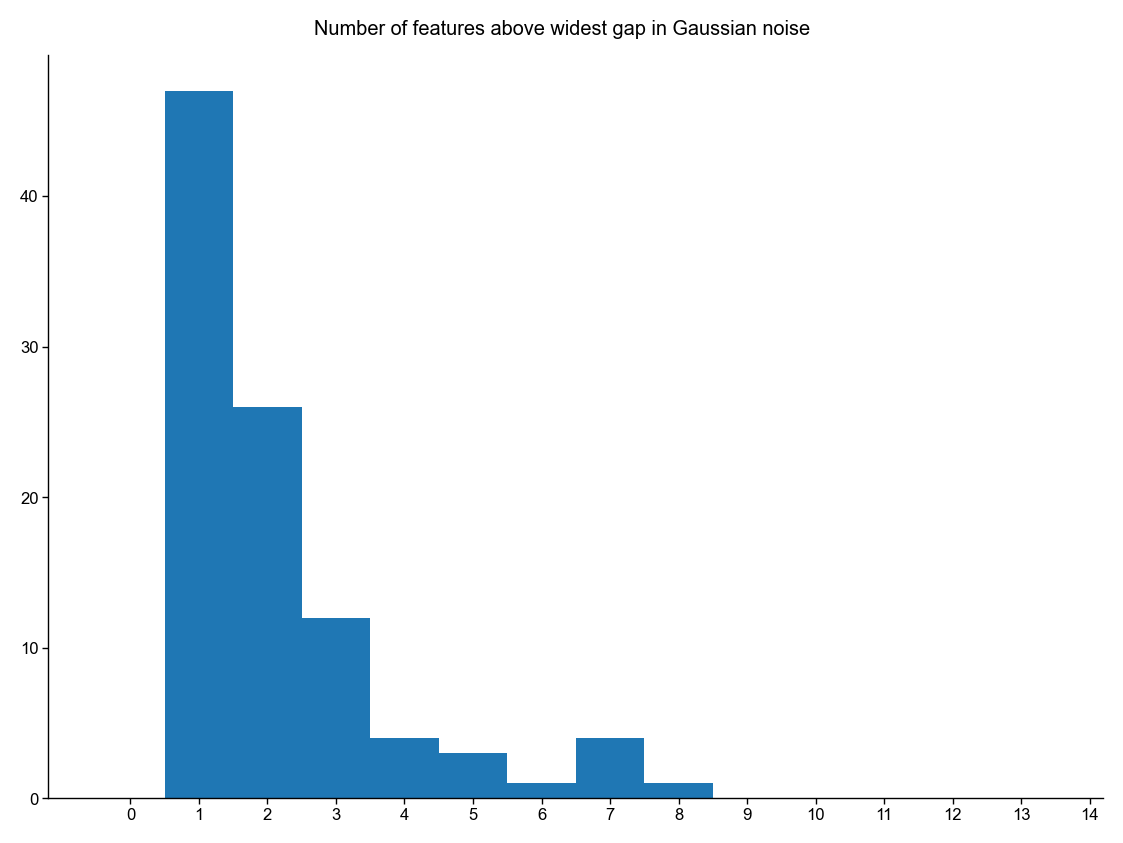

In [105]:
fig, ax = plt.subplots()

ax.hist(n_features_above_widest_gap, bins=np.arange(0, n_features_above_widest_gap.max())-0.5)

ax.set_xticks(np.arange(0, n_features_above_widest_gap.max()))

fig.suptitle("Number of features above widest gap in Gaussian noise")

fig.savefig(os.path.join(fig_path, "fig_widest_gap_gaussian.png"))

In [127]:
## as dimension varies

In [130]:
all_res.keys()

dict_keys([2, 10, 20, 30, 40, 50])

In [133]:
n_features_above_widest_gap = np.array(
    [[len(get_features_above_gap(all_res[embd_dim]["euclidean"]["euclidean"][seed]["dgms"][1], n_gap=0)) for seed in seeds] for embd_dim in embd_dims])


In [134]:
n_features_above_widest_gap.shape

(6, 10)

In [150]:
share_widest_gap = np.array([(n_features_above_widest_gap == i).mean(1) for i in range(1, 4)])
share_widest_gap_std = np.array([(n_features_above_widest_gap == i).std(1) for i in range(1, 4)])

In [151]:
share_widest_gap.shape

(3, 6)

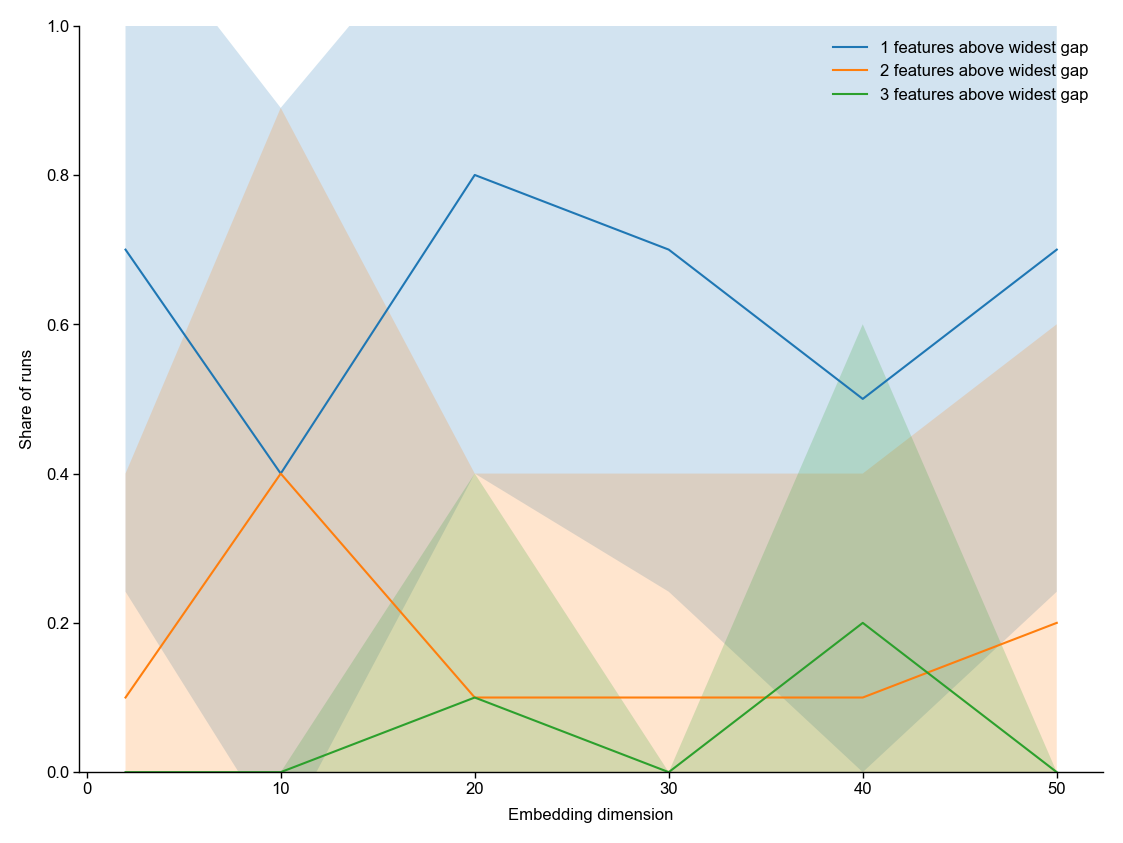

In [152]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(embd_dims, share_widest_gap[i], label=f"{i+1} features above widest gap")
    
    ax.fill_between(embd_dims, share_widest_gap[i] - share_widest_gap_std[i], share_widest_gap[i] + share_widest_gap_std[i], alpha=0.2)
    
    ax.set_xlabel("Embedding dimension")
    ax.set_ylabel("Share of runs")
    ax.set_ylim(0, 1)
    ax.legend()